# Mission3. Ribosome Footprint

## Purpose
To check "the characteristic enrichment of ribosomal footprints in CDS and the three-nucleotide periodicity" (Cho et al., 2012)

***

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'KIM Hyejun'
print(f'Last revised by {name} at {today}.')

Last revised by KIM Hyejun at 2022-05-25.


## Imported Libraries

In [2]:
import sys
import os
from collections import Counter, defaultdict
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pysam

## Files to Use

In [3]:
GENEPRED_PATH    = '../reference-data/genome/mouse/mm39/gencode/mm39.vm28.genepred.txt.gz'
GTF_PATH         = '../reference-data/genome/mouse/mm39/gencode/gencode.vM28.annotation.gtf'
SILUCBAM_PATH    = '../alignments/rpf-siLuc.genome.Aligned.toTranscriptome.out.bam'
SILIN28ABAM_PATH = '../alignments/rpf-siLin28a.genome.Aligned.toTranscriptome.out.bam'

***

## 1. Parse Bams

In [4]:
def parse_aln(fileIn):
    """
    Parse alignments file (SAM or BAM) into Pandas DataFrame.
    Only not-reversed reads were parsed because stranded RNA-seq was done.
    """

    if fileIn.endswith('.sam'):
        iterAlns = pysam.AlignmentFile(fileIn, 'rt')
    else:
        iterAlns = pysam.AlignmentFile(fileIn, 'rb')

    lstAlns = []
    for read in iterAlns:
        if read.is_unmapped: # FLAG 4 == unmapped
            continue # Ignore unmapped
        elif read.is_reverse: # FLAG 16 == reverse
            continue # Ignore reverse mapped
        else:
            readId = read.query_name
            flag   = read.flag
            txId   = read.reference_name
            nPos   = read.reference_start
            lstAlns.append([readId, flag, txId, nPos])

    dfAlns = pd.DataFrame(lstAlns, columns=['read', 'flag', 'tx', 'position'])
    return dfAlns

In [5]:
dfSiLucAlns = parse_aln(SILUCBAM_PATH)
dfSiLucAlns.head()

,read,flag,tx,position
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253
1,rpf-siLuc.602539,256,ENSMUST00000109688.9,1933
2,rpf-siLuc.602539,256,ENSMUST00000130663.10,485
3,rpf-siLuc.602539,256,ENSMUST00000109687.9,521
4,rpf-siLuc.602539,256,ENSMUST00000229270.2,593


In [6]:
dfSiLin28aAlns = parse_aln(SILIN28ABAM_PATH)
dfSiLin28aAlns.head()

,read,flag,tx,position
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758
1,rpf-siLin28a.639,256,ENSMUST00000129473.8,673
2,rpf-siLin28a.639,256,ENSMUST00000100130.10,677
3,rpf-siLin28a.639,256,ENSMUST00000154187.8,786
4,rpf-siLin28a.639,0,ENSMUST00000070653.13,788


In [7]:
len(dfSiLucAlns), len(dfSiLin28aAlns)

(39736361, 29821210)

## 2. Load GenePred
Downloaded from UCSC Table Browser.   
(mm39 vm28 comprehensive)

In [8]:
dfAnno = pd.read_table(GENEPRED_PATH)
del dfAnno['#bin']
print(len(dfAnno))
dfAnno.head()

127843


,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",0,Myog,cmpl,cmpl,"0,0,1,"
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,"
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,"
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,"
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,..."


## 3. Discard Multimapped Reads

In [9]:
def match_tx_to_gene(dfAlns, dfAnno):
    dfAlns = pd.merge(left=dfAlns, right=dfAnno[['name', 'name2']], left_on='tx', right_on='name')[
    ['read', 'flag', 'tx', 'position', 'name2']
]
    dfAlns.columns = ['read', 'flag', 'tx', 'position', 'gene']
    return dfAlns

In [10]:
dfSiLucAlns = match_tx_to_gene(dfSiLucAlns, dfAnno)
dfSiLucAlns.head()

,read,flag,tx,position,gene
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320
1,rpf-siLuc.611756,256,ENSMUST00000170205.2,216,Gm10320
2,rpf-siLuc.632947,0,ENSMUST00000170205.2,119,Gm10320
3,rpf-siLuc.641863,256,ENSMUST00000170205.2,83,Gm10320
4,rpf-siLuc.642180,256,ENSMUST00000170205.2,62,Gm10320


In [11]:
dfSiLin28aAlns = match_tx_to_gene(dfSiLin28aAlns, dfAnno)
dfSiLin28aAlns.head()

,read,flag,tx,position,gene
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3


In [12]:
len(dfSiLucAlns), len(dfSiLin28aAlns)

(33643885, 25735510)

In [13]:
def filter_uniq_mapped(dfAlns):
    # Remove multimapped reads in the same transcripts
    dfAlns['counts'] = 1
    dfReduced = dfAlns[['read', 'tx', 'counts']].groupby(['read', 'tx']).sum()
    stMultiReads = set(dfReduced[dfReduced['counts'] != 1].reset_index()['read'].to_list())
    dfAlns = dfAlns[~dfAlns['read'].isin(stMultiReads)]
    # Remove reads that mapped to more than 2 genes
    dfReduced = dfAlns.drop_duplicates(subset=['read', 'gene'])
    stUniqReads = set(dfReduced.drop_duplicates('read', keep=False)['read'].to_list())
    dfAlns = dfAlns[dfAlns['read'].isin(stUniqReads)]
    return dfAlns

In [14]:
dfSiLucAlns = filter_uniq_mapped(dfSiLucAlns)
dfSiLucAlns.head()

,read,flag,tx,position,gene,counts
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320,1
5,rpf-siLuc.716677,0,ENSMUST00000170205.2,252,Gm10320,1
85,rpf-siLuc.4312494,0,ENSMUST00000170205.2,224,Gm10320,1
134,rpf-siLuc.5510828,0,ENSMUST00000170205.2,253,Gm10320,1
158,rpf-siLuc.6587273,0,ENSMUST00000170205.2,253,Gm10320,1


In [15]:
dfSiLin28aAlns = filter_uniq_mapped(dfSiLin28aAlns)
dfSiLin28aAlns.head()

,read,flag,tx,position,gene,counts
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3,1
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3,1
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3,1
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3,1
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3,1


In [16]:
len(dfSiLucAlns), len(dfSiLin28aAlns)

(29301803, 22521759)

## 4. Calculate Transcripts Length / CDS Length / UTR Length

In [17]:
dfAnno['tx_len'] = dfAnno['exonEnds'].str.split(',').str[:-1].apply(lambda x: sum(map(int, x))) \
               - dfAnno['exonStarts'].str.split(',').str[:-1].apply(lambda x: sum(map(int, x)))
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",0,Myog,cmpl,cmpl,"0,0,1,",1495
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",632
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",429
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467


In [18]:
dfAnno['cds_len'] = dfAnno.apply(
    lambda df: sum(
        int(x) 
        for x in df['exonEnds'].split(',')[:-1] 
        if df['cdsStart'] < int(x) < df['cdsEnd']
    ) - sum(
        int(x)
        for x in df['exonStarts'].split(',')[:-1]
        if df['cdsStart'] < int(x) < df['cdsEnd']
    ) + df['cdsEnd'] - df['cdsStart'], 
    axis=1
)
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",0,Myog,cmpl,cmpl,"0,0,1,",1495,675
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849


In [19]:
dfAnno['first_utr_len'] = dfAnno.apply(
    lambda df: sum(
        int(x)
        for x in df['exonEnds'].split(',')[:-1]
        if int(x) <= df['cdsStart']
    ) - sum(
        int(x)
        for x in df['exonStarts'].split(',')[:-1]
        if int(x) <= df['cdsStart']
    ) + df['cdsStart'],
    axis=1
)
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,first_utr_len
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",0,Myog,cmpl,cmpl,"0,0,1,",1495,675,67
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429,0
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959,692
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849,618


In [20]:
dfAnno['last_utr_len'] = dfAnno.apply(
    lambda df: sum(
        int(x)
        for x in df['exonEnds'].split(',')[:-1]
        if int(x) >= df['cdsEnd']
    ) - sum(
        int(x)
        for x in df['exonStarts'].split(',')[:-1]
        if int(x) >= df['cdsEnd']
    ) - df['cdsEnd'],
    axis=1
)
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,first_utr_len,last_utr_len
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",0,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",0,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429,0,0
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959,692,302
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",0,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849,618,0


In [21]:
dfAnno['utr5_len'] = dfAnno.apply(
    lambda df:
        df['first_utr_len'] if df['strand'] == '+' else df['last_utr_len']
    , axis=1
)

dfAnno['utr3_len'] = dfAnno.apply(
    lambda df:
        df['first_utr_len'] if df['strand'] == '-' else df['last_utr_len']
    , axis=1
)

dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,...,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,first_utr_len,last_utr_len,utr5_len,utr3_len
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",...,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753,67,753
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74,75,74
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429,0,0,0,0
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959,692,302,302,692
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849,618,0,0,618


In [22]:
del dfAnno['first_utr_len']
del dfAnno['last_utr_len']

## 5. Load Transcript Support Level 1 and APPRIS Principal 1 Transcripts Info

In [23]:
tsl1 = set()
appris = set()

tsl1_add = tsl1.add
appris_add = appris.add

pTxId = re.compile(r'transcript_id "(ENSMUST\d+\.\d+)";')

with open(GTF_PATH, 'rt') as fIn:
    for line in fIn:
        if line.startswith('#'):
            continue
        fields = line.strip().split('\t')
        if fields[2] != 'transcript':
            continue
        attribute = fields[8]
        txId = pTxId.findall(attribute)[0]
        if 'transcript_support_level "1";' in attribute:
            tsl1_add(txId)
        if 'tag "appris_principal_' in attribute:
            appris_add(txId)

In [24]:
dfAnno['appris'] = dfAnno['name'].isin(appris)
dfAnno['tsl1']    = dfAnno['name'].isin(tsl1)

In [25]:
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,...,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,utr5_len,utr3_len,appris,tsl1
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",...,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753,True,True
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74,True,True
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429,0,0,False,True
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959,302,692,False,True
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849,0,618,False,True


## 6. Select Protein-coding Transcripts

In [26]:
dfAnno = dfAnno[dfAnno['cdsStartStat'] == 'cmpl'].reset_index(drop=True)
dfAnno

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,...,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,utr5_len,utr3_len,appris,tsl1
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",...,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753,True,True
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74,True,True
2,ENSMUST00000190366.2,chr1,+,16758731,16779761,16758731,16779761,5,"16758731,16761907,16771072,16776396,16779662,","16758843,16761997,16771147,16776449,16779761,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",429,429,0,0,False,True
3,ENSMUST00000126626.8,chr1,-,25106556,25267907,25107248,25265901,16,"25106556,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,-1,-1,",2953,1959,302,692,False,True
4,ENSMUST00000146592.8,chr1,-,25106630,25865220,25107248,25865220,29,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,1,...",4467,3849,0,618,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67160,ENSMUST00000180208.2,chr5_JH584299v1_random,-,910288,913083,910288,913083,3,"910288,911752,912796,","910856,912343,913083,",...,ENSMUSG00000095475,cmpl,cmpl,"2,2,0,",1446,1446,0,0,False,False
67161,ENSMUST00000178327.2,chr5_JH584299v1_random,+,921941,924675,921941,924675,3,"921941,922693,924107,","922228,923284,924675,",...,ENSMUSG00000094855,cmpl,cmpl,"0,2,2,",1446,1446,0,0,False,False
67162,ENSMUST00000177783.2,chr7_GL456219v1_random,-,94185,95088,94185,95088,1,"94185,","95088,",...,Vmn1r186,cmpl,cmpl,"0,",903,903,0,0,False,False
67163,ENSMUST00000177979.2,chr7_GL456219v1_random,-,149260,150163,149260,150163,1,"149260,","150163,",...,ENSMUSG00000096244,cmpl,cmpl,"0,",903,903,0,0,False,False


## 7. Select Major Isoform

Priority:
+ TSL1
+ APPRIS PRINCIPAL
+ Longer tx_len
+ Longer cds_len

In [27]:
dfAnno = dfAnno.sort_values(['name2', 'tsl1', 'appris', 'tx_len', 'cds_len'], ascending=False).drop_duplicates('name2')
dfAnno = dfAnno.sort_index().reset_index(drop=True)
dfAnno

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,...,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,utr5_len,utr3_len,appris,tsl1
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",...,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753,True,True
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74,True,True
2,ENSMUST00000151309.8,chr1,-,25106630,25868788,25107248,25865841,31,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,...",5448,4569,261,618,True,True
3,ENSMUST00000027312.11,chr1,-,33492890,33708876,33493166,33708092,14,"33492890,33503133,33519538,33523762,33551096,3...","33493385,33503202,33519621,33523889,33551282,3...",...,Prim2,cmpl,cmpl,"0,0,1,0,0,2,0,0,0,2,0,1,0,-1,",1975,1518,181,276,True,True
4,ENSMUST00000055313.14,chr1,-,58697278,58735112,58697582,58731572,15,"58697278,58698154,58698381,58700558,58705985,5...","58697589,58698264,58698471,58700621,58706089,5...",...,Flacc1,cmpl,cmpl,"2,0,0,0,1,0,1,2,0,2,0,2,2,0,-1,",1540,1152,84,304,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22443,ENSMUST00000180208.2,chr5_JH584299v1_random,-,910288,913083,910288,913083,3,"910288,911752,912796,","910856,912343,913083,",...,ENSMUSG00000095475,cmpl,cmpl,"2,2,0,",1446,1446,0,0,False,False
22444,ENSMUST00000178327.2,chr5_JH584299v1_random,+,921941,924675,921941,924675,3,"921941,922693,924107,","922228,923284,924675,",...,ENSMUSG00000094855,cmpl,cmpl,"0,2,2,",1446,1446,0,0,False,False
22445,ENSMUST00000177783.2,chr7_GL456219v1_random,-,94185,95088,94185,95088,1,"94185,","95088,",...,Vmn1r186,cmpl,cmpl,"0,",903,903,0,0,False,False
22446,ENSMUST00000177979.2,chr7_GL456219v1_random,-,149260,150163,149260,150163,1,"149260,","150163,",...,ENSMUSG00000096244,cmpl,cmpl,"0,",903,903,0,0,False,False


## 8. Remove Histone mRNAs

In [28]:
HISTONES = (
    'H1f',
    'H2a',
    'Macroh2a',
    'H2b',
    'H3c',
    'H4c'
)

In [29]:
dfSiLucAlns    = dfSiLucAlns[~dfSiLucAlns['gene'].str.startswith(HISTONES)].reset_index(drop=True)
dfSiLucAlns.head()

,read,flag,tx,position,gene,counts
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320,1
1,rpf-siLuc.716677,0,ENSMUST00000170205.2,252,Gm10320,1
2,rpf-siLuc.4312494,0,ENSMUST00000170205.2,224,Gm10320,1
3,rpf-siLuc.5510828,0,ENSMUST00000170205.2,253,Gm10320,1
4,rpf-siLuc.6587273,0,ENSMUST00000170205.2,253,Gm10320,1


In [30]:
dfSiLin28aAlns = dfSiLin28aAlns[~dfSiLin28aAlns['gene'].str.startswith(HISTONES)].reset_index(drop=True)
dfSiLin28aAlns.head()

,read,flag,tx,position,gene,counts
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3,1
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3,1
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3,1
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3,1
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3,1


In [31]:
len(dfSiLucAlns), len(dfSiLin28aAlns)

(29042109, 22340092)

In [32]:
dfAnno = dfAnno[~dfAnno['name2'].str.startswith(HISTONES)].reset_index(drop=True)
dfAnno.head()

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,...,name2,cdsStartStat,cdsEndStat,exonFrames,tx_len,cds_len,utr5_len,utr3_len,appris,tsl1
0,ENSMUST00000027730.6,chr1,+,134217726,134220286,134217793,134219533,3,"134217726,134218830,134219411,","134218264,134218912,134220286,",...,Myog,cmpl,cmpl,"0,0,1,",1495,675,67,753,True,True
1,ENSMUST00000026881.11,chr1,+,16758656,16779835,16758731,16779761,5,"16758656,16761907,16771018,16776396,16779662,","16758843,16761997,16771147,16776449,16779835,",...,Ly96,cmpl,cmpl,"0,1,1,1,0,",632,483,75,74,True,True
2,ENSMUST00000151309.8,chr1,-,25106630,25868788,25107248,25865841,31,"25106630,25113765,25123324,25132845,25137956,2...","25107437,25113870,25123360,25133489,25137996,2...",...,Adgrb3,cmpl,cmpl,"0,0,0,1,0,0,2,2,0,2,1,0,2,0,2,0,2,1,1,0,0,0,1,...",5448,4569,261,618,True,True
3,ENSMUST00000027312.11,chr1,-,33492890,33708876,33493166,33708092,14,"33492890,33503133,33519538,33523762,33551096,3...","33493385,33503202,33519621,33523889,33551282,3...",...,Prim2,cmpl,cmpl,"0,0,1,0,0,2,0,0,0,2,0,1,0,-1,",1975,1518,181,276,True,True
4,ENSMUST00000055313.14,chr1,-,58697278,58735112,58697582,58731572,15,"58697278,58698154,58698381,58700558,58705985,5...","58697589,58698264,58698471,58700621,58706089,5...",...,Flacc1,cmpl,cmpl,"2,0,0,0,1,0,1,2,0,2,0,2,2,0,-1,",1540,1152,84,304,True,True


In [33]:
len(dfAnno)

22346

## 9. Transfer Coordinate
+ Start Codon Centric
+ Stop Codon Centric

In [34]:
dctCdsStart = dfAnno.set_index('name')['utr5_len'].to_dict()
dctCdsStart['ENSMUST00000170205.2']

0

In [35]:
dctCdsEnd = dfAnno.set_index('name')[['tx_len', 'utr3_len']]
dctCdsEnd = dctCdsEnd['tx_len'].sub(dctCdsEnd['utr3_len']).to_dict()
dctCdsEnd['ENSMUST00000170205.2']

342

In [36]:
dfSiLucAlns = dfSiLucAlns[dfSiLucAlns['tx'].isin(dfAnno['name'])].reset_index(drop=True)
print(len(dfSiLucAlns))
dfSiLucAlns.head()

8105571


,read,flag,tx,position,gene,counts
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320,1
1,rpf-siLuc.716677,0,ENSMUST00000170205.2,252,Gm10320,1
2,rpf-siLuc.4312494,0,ENSMUST00000170205.2,224,Gm10320,1
3,rpf-siLuc.5510828,0,ENSMUST00000170205.2,253,Gm10320,1
4,rpf-siLuc.6587273,0,ENSMUST00000170205.2,253,Gm10320,1


In [37]:
dfSiLin28aAlns = dfSiLin28aAlns[dfSiLin28aAlns['tx'].isin(dfAnno['name'])].reset_index(drop=True)
print(len(dfSiLin28aAlns))
dfSiLin28aAlns.head()

6422581


,read,flag,tx,position,gene,counts
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3,1
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3,1
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3,1
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3,1
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3,1


In [39]:
dfSiLucAlns['cds_start_pos']    = dfSiLucAlns.apply(lambda df: df['position'] - dctCdsStart[df['tx']], axis=1)
dfSiLucAlns.head()

,read,flag,tx,position,gene,counts,cds_start_pos
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320,1,253
1,rpf-siLuc.716677,0,ENSMUST00000170205.2,252,Gm10320,1,252
2,rpf-siLuc.4312494,0,ENSMUST00000170205.2,224,Gm10320,1,224
3,rpf-siLuc.5510828,0,ENSMUST00000170205.2,253,Gm10320,1,253
4,rpf-siLuc.6587273,0,ENSMUST00000170205.2,253,Gm10320,1,253


In [41]:
dfSiLin28aAlns['cds_start_pos'] = dfSiLin28aAlns.apply(lambda df: df['position'] - dctCdsStart[df['tx']], axis=1)
dfSiLin28aAlns.head()

,read,flag,tx,position,gene,counts,cds_start_pos
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3,1,572
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3,1,167
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3,1,510
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3,1,1176
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3,1,1068


In [42]:
dfSiLucAlns['cds_end_pos']    = dfSiLucAlns.apply(lambda df: df['position'] - dctCdsEnd[df['tx']], axis=1)
dfSiLucAlns.head()

,read,flag,tx,position,gene,counts,cds_start_pos,cds_end_pos
0,rpf-siLuc.602538,0,ENSMUST00000170205.2,253,Gm10320,1,253,-89
1,rpf-siLuc.716677,0,ENSMUST00000170205.2,252,Gm10320,1,252,-90
2,rpf-siLuc.4312494,0,ENSMUST00000170205.2,224,Gm10320,1,224,-118
3,rpf-siLuc.5510828,0,ENSMUST00000170205.2,253,Gm10320,1,253,-89
4,rpf-siLuc.6587273,0,ENSMUST00000170205.2,253,Gm10320,1,253,-89


In [43]:
dfSiLin28aAlns['cds_end_pos']    = dfSiLin28aAlns.apply(lambda df: df['position'] - dctCdsEnd[df['tx']], axis=1)
dfSiLin28aAlns.head()

,read,flag,tx,position,gene,counts,cds_start_pos,cds_end_pos
0,rpf-siLin28a.639,256,ENSMUST00000168579.8,758,Slc16a3,1,572,-841
1,rpf-siLin28a.1269,256,ENSMUST00000168579.8,353,Slc16a3,1,167,-1246
2,rpf-siLin28a.2862,256,ENSMUST00000168579.8,696,Slc16a3,1,510,-903
3,rpf-siLin28a.4344,256,ENSMUST00000168579.8,1362,Slc16a3,1,1176,-237
4,rpf-siLin28a.6658,256,ENSMUST00000168579.8,1254,Slc16a3,1,1068,-345


## 10. Plot

In [56]:
dfPlot = pd.DataFrame(
    {'siLuc_start':Counter(
        dfSiLucAlns['cds_start_pos'][dfSiLucAlns['cds_start_pos'].isin(range(-50, 51))]
    ),
    'siLuc_end':Counter(
        dfSiLucAlns['cds_end_pos'][dfSiLucAlns['cds_end_pos'].isin(range(-50, 51))]
    ),
    'siLin28a_start':Counter(
        dfSiLin28aAlns['cds_start_pos'][dfSiLin28aAlns['cds_start_pos'].isin(range(-50, 51))]
    ),
    'siLin28a_end':Counter(
        dfSiLin28aAlns['cds_end_pos'][dfSiLin28aAlns['cds_end_pos'].isin(range(-50, 51))]
    )}
)
dfPlot.sort_index(inplace=True)
dfPlot

,siLuc_start,siLuc_end,siLin28a_start,siLin28a_end
-50,6561,1106,4286,844
-49,6364,9759,4459,7761
-48,6721,13022,4925,11390
-47,6154,1263,4660,947
-46,4881,9503,3325,8014
...,...,...,...,...
46,2083,77,1519,52
47,7355,57,5301,76
48,9026,57,7264,48
49,1638,66,1250,39


In [67]:
COLS = [dfPlot.columns[:2], dfPlot.columns[2:]]
COLS

[Index(['siLuc_start', 'siLuc_end'], dtype='object'),
 Index(['siLin28a_start', 'siLin28a_end'], dtype='object')]

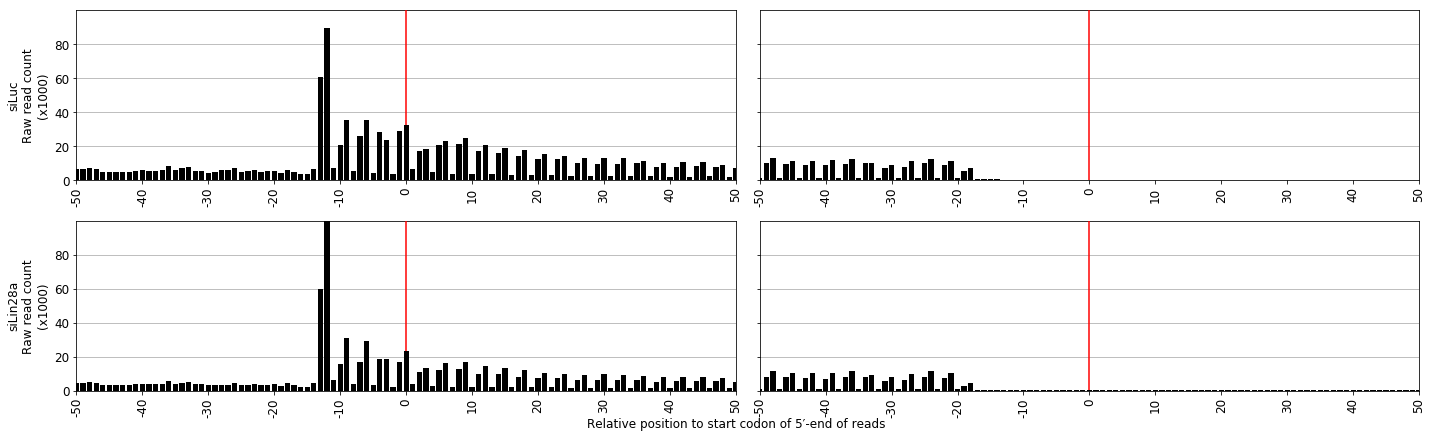

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(20, 6), sharey=True)
for i, cols in enumerate(COLS):
    for j, col in enumerate(cols):
        axes[i, j].bar(x=dfPlot.index, height=col, data=dfPlot, color='k', zorder=10)
        axes[i, j].axvline(0, color='r', zorder=5)
        
        axes[i, j].set_xlim(-50, 50)
        axes[i, j].set_ylim(0, 100000)
        
        axes[i, j].set_xticks(range(-50, 51, 10))
        axes[i, j].set_xticklabels(labels=range(-50, 51, 10), rotation=90, fontsize=12)
        axes[i, j].set_yticks(range(0, 100000, 20000))
        axes[i, j].set_yticklabels(labels=range(0, 100, 20), fontsize=12)
        
        axes[i, j].grid(axis='y')
        if not j:
            axes[i, j].set_ylabel(f'{col.split("_")[0]}\nRaw read count\n(x1000)', fontsize=12)
        
fig.text(0.41, 0, 'Relative position to start codon of 5′-end of reads', fontsize=12)
fig.tight_layout()